# Reciprocal Relationship between Bartering and Selling
- When it comes to game exchange, do people prefer to exchange the game with someone who has exchanged before or someone who has not exchanged before? 
- What's the difference between game sales and game exchange?

Here, we use logistic regression.

## 0. Load the data

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
os.getcwd()

'/home/jliu/project'

In [3]:
# Load the data from pickle file
with open('./data/transaction_history_all.pickle', 'rb') as f:
    data_with_user = pd.read_pickle(f)

# Choose only the data before 2019-01-01
data_with_user = data_with_user.loc[data_with_user['created_utc']<='2018-12-31']

In [4]:
print(os.getcwd())

/home/jliu/project


In [6]:
with open("./data/df_pre2019_original.pickle", 'rb') as f:
     data_with_original = pd.read_pickle(f)
data_with_original.head()

,user,index,author,body,created_utc,permalink,reply_author,reply_body,type,pred,subreddit,url,created_utc_original
6,rdmentalist,rdmentalist_2,MrAce2C,Successful trade with u/rdmentalist. Gave Gear...,2016-10-23 21:59:35,/r/gameswap/comments/543ojp/completed_trade_th...,rdmentalist,Confirmed.,gameswap,NaN,gameswap,r/gameswap/comments/5906ut,2016-10-23 19:16:49
9,rdmentalist,rdmentalist_5,TradlyGent,swapped a 20% PSN code for Gears of War 1 and ...,2018-07-03 17:19:14,/r/gameswap/comments/7q4pkv/completed_swap_thr...,rdmentalist,Confirmed.,gameswap,NaN,gameswap,r/gameswap/comments/8pg7m1,2018-06-08 02:20:56
10,rdmentalist,rdmentalist_6,keokidream,Successful trade with /u/rdmentalist\n\nCall o...,2016-06-17 14:54:23,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed! thanks,gameswap,NaN,gameswap,r/gameswap/comments/4ogyyf,2016-06-17 01:58:26
11,rdmentalist,rdmentalist_7,testicles_two,"Traded Gears of War 1,2,3 and Judgement for $1...",2016-06-23 23:55:01,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed ! thanks,gameswap,NaN,gameswap,r/gameswap/comments/4ovjzx,2016-06-19 22:29:56
12,rdmentalist,rdmentalist_8,walterpwn,Successful trade with [/u/rdmentalist](https:/...,2016-05-12 19:43:00,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed :),gameswap,NaN,gameswap,r/gameswap/comments/4iuc98,2016-05-11 10:49:48


In [7]:
data_with_original['user']=data_with_user['user']
data = data_with_original.copy()
display(data.head())

,user,index,author,body,created_utc,permalink,reply_author,reply_body,type,pred,subreddit,url,created_utc_original
6,rdmentalist,rdmentalist_2,MrAce2C,Successful trade with u/rdmentalist. Gave Gear...,2016-10-23 21:59:35,/r/gameswap/comments/543ojp/completed_trade_th...,rdmentalist,Confirmed.,gameswap,NaN,gameswap,r/gameswap/comments/5906ut,2016-10-23 19:16:49
9,rdmentalist,rdmentalist_5,TradlyGent,swapped a 20% PSN code for Gears of War 1 and ...,2018-07-03 17:19:14,/r/gameswap/comments/7q4pkv/completed_swap_thr...,rdmentalist,Confirmed.,gameswap,NaN,gameswap,r/gameswap/comments/8pg7m1,2018-06-08 02:20:56
10,rdmentalist,rdmentalist_6,keokidream,Successful trade with /u/rdmentalist\n\nCall o...,2016-06-17 14:54:23,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed! thanks,gameswap,NaN,gameswap,r/gameswap/comments/4ogyyf,2016-06-17 01:58:26
11,rdmentalist,rdmentalist_7,testicles_two,"Traded Gears of War 1,2,3 and Judgement for $1...",2016-06-23 23:55:01,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed ! thanks,gameswap,NaN,gameswap,r/gameswap/comments/4ovjzx,2016-06-19 22:29:56
12,rdmentalist,rdmentalist_8,walterpwn,Successful trade with [/u/rdmentalist](https:/...,2016-05-12 19:43:00,/r/gameswap/comments/4c351t/completed_trade_th...,rdmentalist,Confirmed :),gameswap,NaN,gameswap,r/gameswap/comments/4iuc98,2016-05-11 10:49:48


## 1. Preprocessing
- The bot may record wrongly the confirmantion.
- Some Reddit users may delete their accounts.

**We ignore these cases by deleting these rows.**

In [8]:
# Select the rows that have a user that is not deleted.
data = data.loc[~data['user'].isna()]

print("Number of deleted users: ", data.loc[(data['author']=='[deleted]')|(data['reply_author']=='[deleted]')].shape[0])
data = data.loc[(data['author']!='[deleted]') & (data['reply_author']!='[deleted]')]

print("Remaining rows of confirmantion data:", data.shape[0])
# data['created_utc'].describe(datetime_is_numeric=True)

Number of deleted users:  1514
Remaining rows of confirmantion data: 27190


## 2. Active users

In [9]:
data_sale = data.loc[data['type']=='gamesale']
data_swap = data.loc[data['type']=='gameswap']

swap_user = set(data_swap['author'])
sale_user = set(data_sale['author'])
both_user = swap_user.intersection(sale_user)

print("Active users in r/GameSwap:", len(swap_user))
print("Active users in r/GameSale:", len(sale_user))
print("Active users in both communities:", len(both_user))

Active users in r/GameSwap: 1380
Active users in r/GameSale: 2683
Active users in both communities: 424


## 3. Interactions

In [10]:
# Get the months in created_utc
data['month']=data['created_utc'].dt.to_period('M')
months = data['month'].sort_values().unique()

# Get the number of transactions in each month.
# So we can see if two users have ever interacted in the given month.
transaction_at_month = data.groupby(['author', 'reply_author', 'type', 'month', 'user']).size().reset_index(name='count')

In [11]:
interactions = transaction_at_month.pivot(index=['author','reply_author','month','user'], columns='type', values='count').fillna(0).astype(int).reset_index().rename_axis(None, axis=1)
interactions['total'] = interactions['gamesale'] + interactions['gameswap']

# Lowercase the author and reply_author
interactions['author'] = interactions['author'].str.lower()
interactions['reply_author'] = interactions['reply_author'].str.lower()

# Drop the rows that have the same author, reply_author, and month because each transaction will be counted twice because that there are two users.
interactions = interactions.drop_duplicates(subset=['author','reply_author','month'], keep='first')

# Create a new column called pair, is the set of (author, reply_author, user)
# So this column can be used to check if two users have ever interacted.
interactions['pair'] = interactions.apply(lambda x: set(sorted([x['author'], x['reply_author'], x['user']])), axis=1)

In [12]:
# temp = interactions.sort_values(by=['author','reply_author','month'],).iloc[3:5,:]['pair'].values
# print(temp)
# temp[0]==temp[1]

## 4. Cumulative Transactions
Here we store the cumulative transactions of user till each month.

In [13]:
tranc = data.groupby(['user','type','month']).size().reset_index(name='count').pivot(index=['user','month'], columns='type', values='count').fillna(0).astype(int).reset_index().rename_axis(None, axis=1)
tranc['year'] = tranc['month'].dt.year

In [14]:
cumulative_transactions = {}
for month in months:
    # Get the total transactions of a user no later than the given month
    cumulative_transactions[month] = data.loc[data['month'] <= month].groupby(['user','type']).size().reset_index(name='count').pivot(index='user', columns='type', values='count').fillna(0).astype(int)
    if 'gamesale' not in cumulative_transactions[month].columns:
        cumulative_transactions[month]['gamesale'] = 0
    cumulative_transactions[month]['total'] = cumulative_transactions[month]['gamesale'] + cumulative_transactions[month]['gameswap']
    cumulative_transactions[month] = cumulative_transactions[month].reset_index().rename_axis(None, axis=1)
    # Add the month column
    cumulative_transactions[month]['month'] = month

# Combine all the dataframes into one, called trans_till_month
trans_till_month = pd.concat(cumulative_transactions.values(), ignore_index=True)
# Add a year column
trans_till_month['year'] = trans_till_month['month'].dt.year


## 5. Analysis

### 5.1 Relationship between Bartering and Selling

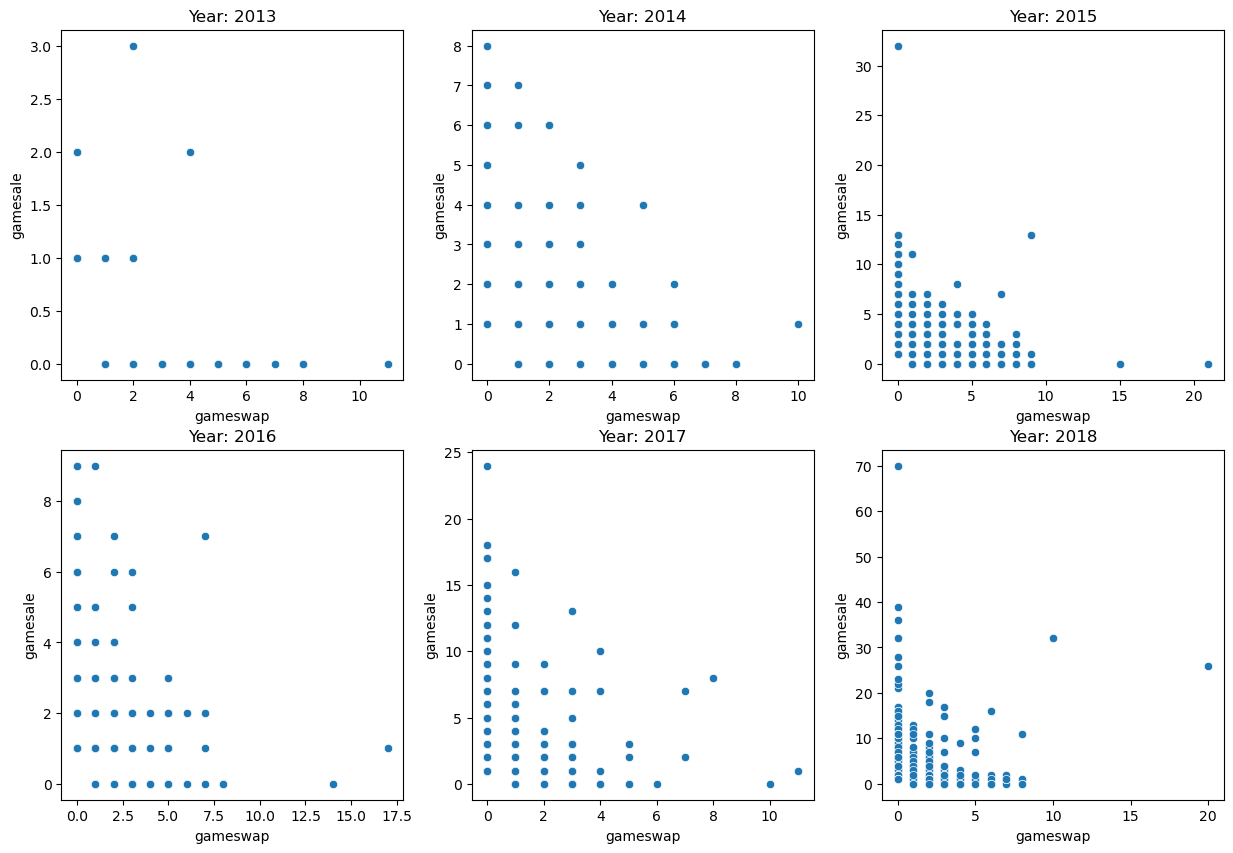

<Figure size 640x480 with 0 Axes>

In [15]:
# Plot each year's relationship between gameswap and gamesale, 6 plots in total, tranc
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, year in enumerate(sorted(tranc['year'].unique())):
    ax = axes[i//3, i%3]
    ax.set_title('Year: '+str(year))
    sns.scatterplot(x='gameswap', y='gamesale', data=tranc.loc[tranc['year']==year], ax=ax)

plt.show()
plt.savefig('plot/transaction_per_year.png')


### 2.1 Get transactions tuple
For each month $t$, if in month $t+1$, users $A$ and $B$ have an transaction, then we store tuple $(A_t, B_t, t)$, where $A_t$ is the number of cumulative transactions of user $A$ till month $t$.

In [16]:
def merge_by_author(pre_month, current_month, current_data):
    temp = pd.merge(current_data, cumulative_transactions[pre_month][['user','total']], left_on=current_data['author'].str.lower(), right_on='user', how='left')
    final = pd.merge(temp, cumulative_transactions[pre_month][['user','total']], left_on=temp['reply_author'].str.lower(), right_on='user', how='left')
    final = final.drop(['user','user_x','user_y'], axis=1)
    final = final.rename(columns={'total_x':'author_total','total_y':'reply_author_total'})
    final = final.fillna(0)
    return final

In [17]:
df_all = []
for pre_month, current_month in zip(months[::], months[1::]):
    # Get the users who have interacted in the current month
    current_data = interactions.loc[(interactions['month']==current_month)&(interactions['total']>=1)][['author','reply_author']]
    
    processed_current = merge_by_author(pre_month, current_month, current_data)
    processed_current['month'] = pre_month
    df_all.append(processed_current)

df_all = pd.concat(df_all)

In [18]:
df_all

,author,reply_author,author_total,reply_author_total,month
0,3gsid,marcymarcmarc,1.0,5.0,2013-10
1,arcanis888,0nlyher0,1.0,1.0,2013-10
2,autoham,rheally,2.0,0.0,2013-10
3,betaboy23,zerox2306,1.0,0.0,2013-10
4,betom,dannydrabik,0.0,0.0,2013-10
...,...,...,...,...,...
287,yugidementia,lucario_ftw,3.0,2.0,2018-11
288,yugidementia,stela_thylacine,3.0,0.0,2018-11
289,yugidementia,arandomuzzerame,3.0,36.0,2018-11
290,yugidementia,bulldawgblitz,3.0,13.0,2018-11


In [19]:
# Add a column of year
df_all['year'] = df_all['month'].dt.year
df_all

,author,reply_author,author_total,reply_author_total,month,year
0,3gsid,marcymarcmarc,1.0,5.0,2013-10,2013
1,arcanis888,0nlyher0,1.0,1.0,2013-10,2013
2,autoham,rheally,2.0,0.0,2013-10,2013
3,betaboy23,zerox2306,1.0,0.0,2013-10,2013
4,betom,dannydrabik,0.0,0.0,2013-10,2013
...,...,...,...,...,...,...
287,yugidementia,lucario_ftw,3.0,2.0,2018-11,2018
288,yugidementia,stela_thylacine,3.0,0.0,2018-11,2018
289,yugidementia,arandomuzzerame,3.0,36.0,2018-11,2018
290,yugidementia,bulldawgblitz,3.0,13.0,2018-11,2018


In [20]:
# Reverse column 1 and 2,  3 and 4
df_all_reverse = df_all.copy()
df_all_reverse[['author','reply_author']] = df_all_reverse[['reply_author','author']]
df_all_reverse[['author_total','reply_author_total']] = df_all_reverse[['reply_author_total','author_total']]

df = pd.concat([df_all, df_all_reverse])

In [21]:
# Get author_total == 1
cum_year = df.loc[(df['author_total']<=0) & 
                  (df['reply_author_total']<=100) &
                  (df['reply_author_total']>=0)]
data_to_plot = [cum_year.loc[cum_year['year']==year,'reply_author_total'] for year in range(2014,2019)]


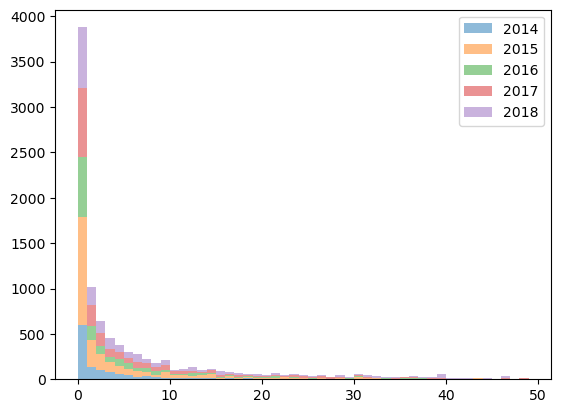

In [22]:
plt.hist(data_to_plot,  alpha=0.5, label=[2014,2015,2016,2017,2018], bins=range(0,50,1), stacked=True, )
plt.legend(loc='upper right')